In [156]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

import torch as th
import torch.nn as nn
from stable_baselines3.dqn.policies import DQNPolicy

In [157]:
import grid2op
print(grid2op.__version__)

1.10.5


- #### `Initialise` the environment

In [133]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward
     

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
         )

        # Set combined reward
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.relevantObservations = [
        "minute_of_hour"
        ,"gen_p"
        ,"gen_q"
        ,"gen_v"
        ,"gen_theta"
        ,"load_p"
        ,"load_q"
        ,"load_v"
        ,"load_theta"
        ,"rho"
        ,"line_status"
        ,"topo_vect"
        ,"time_next_maintenance"
        ,"target_dispatch"
        ,"actual_dispatch"
        ,"current_step"
        ,"max_step" 
        ]

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # # Flatten the observation space  ///Initial observations without any modifications
        # sample_obs, _ = self._gym_env.reset()
        # flat_obs = self.flatten_observation(sample_obs)
        # obs_size = flat_obs.shape[0]
        # self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

        # /// Modified observations
        sample_obs, _ = self._gym_env.reset()
        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = sample_obs[observation]
        # print("MIn obs:",min_obs)
        flat_obs = self.flatten_observation(min_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []
        num_powerlines =10
        num_generators = 6
        num_sub_stations = 16

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        # # Action 1: Open line 0
        # open_line_0 = action_space({"set_line_status": [(0, -1)]})
        # gym_open_line_0 = self._gym_env.action_space.to_gym(open_line_0)
        # self.available_actions.append(gym_open_line_0)

        # # Action 2: Close line 0
        # close_line_0 = action_space({"set_line_status": [(0, 1)]})
        # gym_close_line_0 = self._gym_env.action_space.to_gym(close_line_0)
        # self.available_actions.append(gym_close_line_0)

        #  Open and Close all powerlines
        for line in range(num_powerlines):
            close_line = action_space({"set_line_status":[(line,-1)]})
            gym_close_line = self._gym_env.action_space.to_gym(close_line)
            open_line = action_space({"set_line_status":[(line,1)]})
            gym_open_line = self._gym_env.action_space.to_gym(open_line)
            self.available_actions.append(gym_close_line)
            self.available_actions.append(gym_open_line)

        # Redispatch all generators
        for generator in range(num_generators):
            redispatch_gen = action_space({"redispatch":[(generator,2.5)]})
            gym_redispatch_gen = self._gym_env.action_space.to_gym(redispatch_gen)
            self.available_actions.append(gym_redispatch_gen)

        # Add more actions as needed
        # For example, open/close other lines

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))

        # Print the action mappings
        # print("Available actions:")
        # for idx, action in enumerate(self.available_actions):
        #     print(f'action {idx}: {action}')

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        # obs = self.flatten_observation(obs)
        # return obs, info
        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = obs[observation]
        obs = self.flatten_observation(min_obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        # obs = self.flatten_observation(obs)

        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = obs[observation]
        obs = self.flatten_observation(min_obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components
        
        return obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [134]:
def test_environment():
    env = Gym2OpEnv()
    obs, info = env.reset(seed=12)
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Initial observation shape: (200,)
Initial observation: [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  7.9599998e+01
  7.8000000e+01  2.0299999e+01  0.0000000e+00  0.0000000e+00
  7.5894516e+01  1.9370398e+01  7.4134529e+01  2.2987965e+01
  2.2987965e+01  2.4470367e+01 -1.6485050e+01 -1.3930471e+00
 -4.0993605e+00 -8.0236607e+00 -8.0236607e+00 -7.6959491e+00
  0.0000000e+00  1.4210001e+02  1.4210001e+02  2.2000000e+01
  2.2000000e+01  1.3200001e+01  1.4210001e+02  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  2.3299999e+01
  8.7300003e+01  4.6599998e+01  7.0999999e+00  1.1700000e+01
  2.8400000e+01  8.8000002e+00  3.5000000e+00  5.5000000e+00
  1.2700000e+01  1.5000000e+01

-  #### `Print` observation space and action space

In [17]:
def test_environment():
    env = Gym2OpEnv()

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

In [ ]:
test_environment()

- #### `Test` the environment

In [ ]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

# Implement your agent here

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11       |
|    ep_rew_mean      | 2.37     |
|    exploration_rate | 0.957    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 47       |
|    time_elapsed     | 0        |
|    total_timesteps  | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.5      |
|    ep_rew_mean      | 1.49     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 41       |
|    time_elapsed     | 1        |
|    total_timesteps  | 68       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 8.5      |
|    ep_rew_mean      | 1.42   

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and

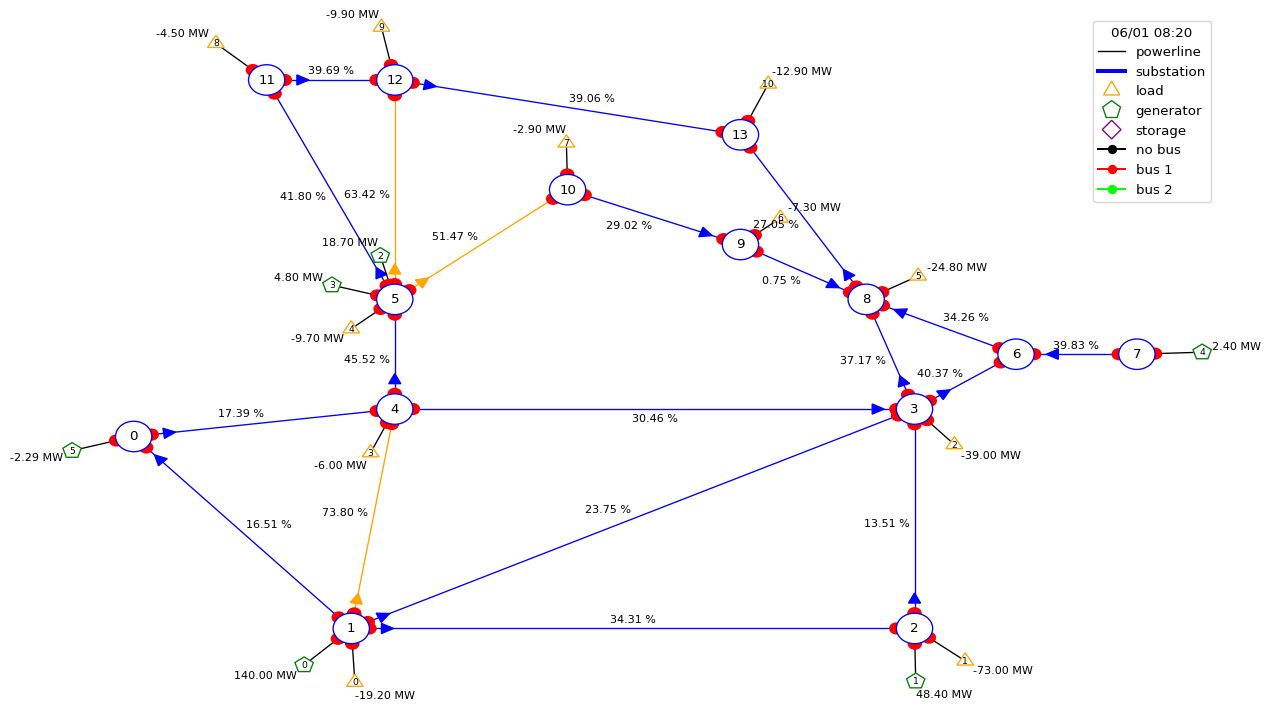

In [135]:
def train_dqn_agent():
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1,
            learning_rate=0.0005,
            buffer_size=100000,
            batch_size=32,
            gamma=0.99,
            exploration_fraction=0.1,
            exploration_final_eps=0.02)
    model.learn(total_timesteps=10000)
    model.save("dqn_grid2op_agent")

    # Evaluate the trained model
    obs, _ = env.reset(seed=12)
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Evaluate` the environment

In [140]:
def evaluate_agent(model, env, num_episodes=10):
    episode_rewards = []
    reward_sum = 0
    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        reward_sum += total_reward
    print(f"Average Reward:", reward_sum/num_episodes)
    print(f"Total reward:",reward_sum)
    return episode_rewards,(reward_sum/num_episodes)

- #### `Run` the evaluation function

In [141]:
if __name__ == "__main__":
    # Initialize the environment and model
    env = Gym2OpEnv()
    model = DQN("MlpPolicy", env, verbose=1)
    
    # Load the trained model (optional)
    model = DQN.load("dqn_grid2op_agent", env=env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 20
    rewards,average = evaluate_agent(model, env, num_episodes=num_evaluation_episodes)

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = 268.1452095210552
Episode 2: Total Reward = 1567.3029865175486
Episode 3: Total Reward = 870.7465864121914
Episode 4: Total Reward = 2347.699774160981
Episode 5: Total Reward = 1959.4963975399733
Episode 6: Total Reward = 1056.5338168293238
Episode 7: Total Reward = 433.46572428941727
Episode 8: Total Reward = 366.2164732962847
Episode 9: Total Reward = 281.2962398827076
Episode 10: Total Reward = 382.5044099390507
Episode 11: Total Reward = 1038.3458653390408
Episode 12: Total Reward = 372.26637513935566
Episode 13: Total Reward = 1625.9882570654154
Episode 14: Total Reward = 282.7306272983551
Episode 15: Total Reward = 237.07497850060463
Episode 16: Total Reward = 366.49944157898426
Episode 17: Total Reward = 1062.5586376786232
Episode 18: Total Reward = 887.1421447843313
Episode 19: Total 

- #### `Visualise` the results



In [147]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


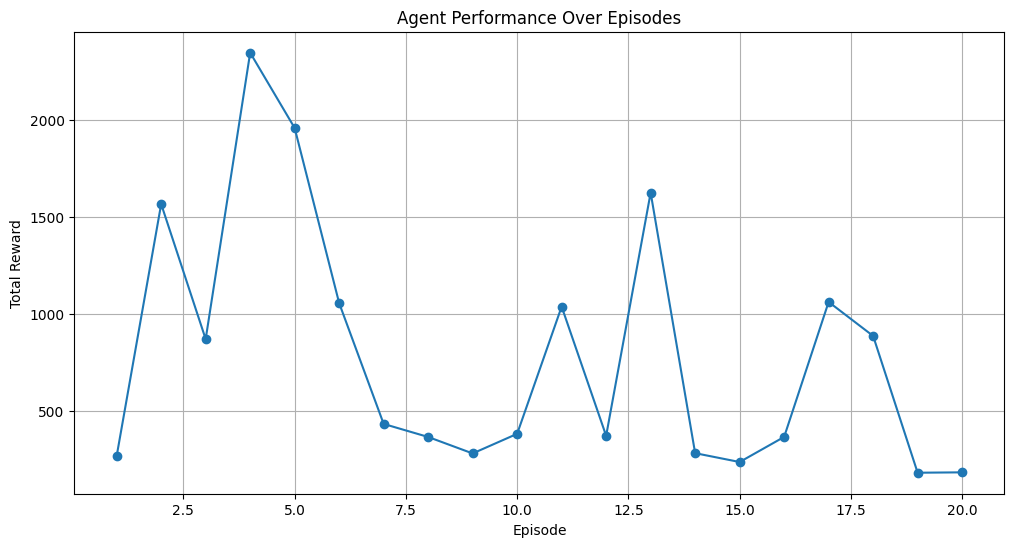

In [148]:
# call plot function
plot_rewards(rewards)

#1:173,776
#2:175.198225319385
#3:175.198

- ### `Reward Shaping` to encourage agent make better decisions

In [150]:
from grid2op.Reward import BaseReward

class CustomTrainingReward(BaseReward):
    def __init__(self):
        super().__init__()
    
    def initialize(self, env):
        super().initialize(env)
    
    def reset(self, env):
        super().reset(env)
    
    def __call__(self, action, env, has_error, is_done, is_illegal, is_ambiguous):
        # Compute the custom reward
        reward = 0.0

        # Access the current observation
        current_obs = env.current_obs

        # Get the maximum line loading (rho)
        max_rho = current_obs.rho.max()

        # Penalize line overloads
        if max_rho > 1.0:
            overload_amount = max_rho - 1.0
            reward -= overload_amount * 10  # Penalty proportional to overload

        # Reward safe operation
        elif max_rho < 0.8:
            reward += 1.0  # Reward for keeping lines below 80% capacity

        # Create a "do nothing" action
        do_nothing_action = env.action_space()

        # Penalize unnecessary actions to encourage efficiency
        if not action == do_nothing_action and not is_illegal:
            reward -= 0.1  # Small penalty for taking an action

        # Penalize illegal actions
        if is_illegal:
            reward -= 5.0  # Heavy penalty for illegal actions

        # Additional penalties or rewards based on other parameters
        if has_error:
            reward -= 10.0  # Penalty for errors

        if is_done and has_error:
            reward -= 20.0  # Penalty if the episode ends due to failure

        return reward



In [175]:
class Gym2OpEnvRS(gym.Env):
    def __init__(self, seed=None, training =True):
        super().__init__()
        self.training = training # Indicates whether we're training or evaluating
        self.seed_value = seed

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
       
        # If training use custom reward class else use combined reward
        if self.training:
            reward_class = CustomTrainingReward
        else:
            reward_class = CombinedScaledReward

      
        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4


        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        # Set the seed for the Grid2Op environment
        if self.seed_value is not None:
            self._g2op_env.seed(seed_value)


        # Conditionally set up combined reward components
        if not self.training:
            # Only add reward components when not training
            cr = self._g2op_env.get_reward_instance()
            cr.addReward("N1", N1Reward(), 1.0)
            cr.addReward("L2RPN", L2RPNReward(), 1.0)
            cr.initialize(self._g2op_env)

        self.relevantObservations = [
        "minute_of_hour"
        ,"gen_p"
        ,"gen_q"
        ,"gen_v"
        ,"gen_theta"
        ,"load_p"
        ,"load_q"
        ,"load_v"
        ,"load_theta"
        ,"rho"
        ,"line_status"
        ,"topo_vect"
        ,"time_next_maintenance"
        ,"target_dispatch"
        ,"actual_dispatch"
        ,"current_step"
        ,"max_step" 
        ]

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = sample_obs[observation]
        flat_obs = self.flatten_observation(min_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []
        num_powerlines =10
        num_generators = 6

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

         #Open and Close all powerlines
        for line in range(num_powerlines):
            close_line = action_space({"set_line_status":[(line,-1)]})
            gym_close_line = self._gym_env.action_space.to_gym(close_line)
            open_line = action_space({"set_line_status":[(line,1)]})
            gym_open_line = self._gym_env.action_space.to_gym(open_line)
            self.available_actions.append(gym_close_line)
            self.available_actions.append(gym_open_line)

        # Redispatch all generators
        for generator in range(num_generators):
            redispatch_gen = action_space({"redispatch":[(generator,2.5)]})
            gym_redispatch_gen = self._gym_env.action_space.to_gym(redispatch_gen)
            self.available_actions.append(gym_redispatch_gen)

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))


    def reset(self, seed=None):
        if seed is not None:
            self.seed_value = seed

        obs, info = self._gym_env.reset(seed=seed, options=None)
        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = obs[observation]
        obs = self.flatten_observation(min_obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)

        min_obs = {}
        for observation in self.relevantObservations:
            min_obs[observation] = obs[observation]
        obs = self.flatten_observation(min_obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components
        
        return obs, reward, terminated, truncated, info

    def render(self, mode='human'):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

In [176]:
def test_environment():
    env = Gym2OpEnvRS(training= True)
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Reward\rewardHelper.py:131: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.logger.warn(f"Reward \"{reward_func.__name__}\" does not support the logger feature. Error was : {exc_}")


Initial observation shape: (200,)
Initial observation: [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  8.1699997e+01
  8.1000000e+01  1.2800000e+01  0.0000000e+00  0.0000000e+00
  7.7924316e+01  2.0203350e+01  7.2852829e+01  2.4498531e+01
  2.4498531e+01  2.4855238e+01 -1.6197826e+01 -1.4019026e+00
 -4.0007744e+00 -8.9687719e+00 -8.9687719e+00 -8.0970535e+00
  0.0000000e+00  1.4210001e+02  1.4210001e+02  2.2000000e+01
  2.2000000e+01  1.3200001e+01  1.4210001e+02  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00
  1.0000000e+00  1.0000000e+00  1.0000000e+00  2.2799999e+01
  8.6699997e+01  4.5299999e+01  7.0999999e+00  1.2200000e+01
  2.8900000e+01  9.1999998e+00  3.5000000e+00  5.5999999e+00
  1.2800000e+01  1.5200000e+01

- ### `Implementing a new exploration strategy` (Boltzmann Exploration)

In [177]:
class BoltzmannPolicy(DQNPolicy):
    def __init__(self, *args, temperature=1.0, **kwargs):
        super(BoltzmannPolicy, self).__init__(*args, **kwargs)
        self.temperature = temperature

    def _predict(self, obs, deterministic=False):
        q_values = self.q_net(obs)
        if deterministic:
            # Exploit: choose action with highest Q-value
            actions = q_values.argmax(dim=1)
        else:
            # Explore: sample actions using Boltzmann distribution
            probabilities = th.softmax(q_values / self.temperature, dim=1)
            actions = probabilities.multinomial(num_samples=1).squeeze(1)
        return actions


- ### `DQN` Agent

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Reward\rewardHelper.py:131: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self.logger.warn(f"Reward \"{reward_func.__name__}\" does not support the logger feature. Error was : {exc_}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | -39.5    |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 35       |
|    time_elapsed     | 0        |
|    total_timesteps  | 17       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11       |
|    ep_rew_mean      | -35.2    |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 92       |
|    time_elapsed     | 0        |
|    total_timesteps  | 88       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.1     |
|    ep_rew_mean      | -38.4  

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  rgb_array = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(self._viewer.height, self._viewer.width, 3)
c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\grid2op\Environment\environment.py:1415: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and

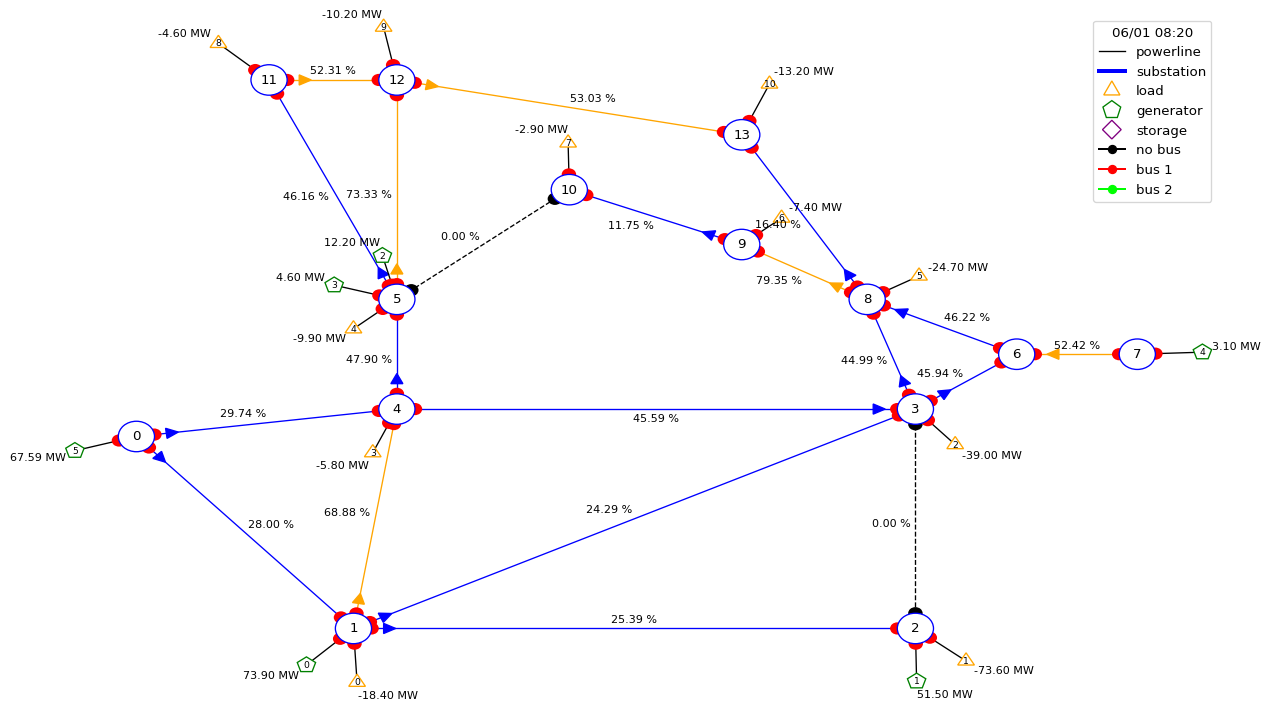

In [178]:
def train_dqn_agent():
    env = Gym2OpEnvRS(training=True) # Initialise env with seed

    model = DQN(policy=BoltzmannPolicy,
            env=env,
            learning_rate=1e-4,
            buffer_size=100000,
            learning_starts=1000,
            batch_size=32,
            tau=1.0,
            gamma=0.99,
            train_freq=4,
            gradient_steps=1,
            verbose=1,
            target_update_interval=1000,
            policy_kwargs={'temperature': 1.0},
        )
    
    model.learn(total_timesteps=10000)
    model.save("dqn_boltzmann_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Run` the evaluation function

c:\Users\widas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode 1: Total Reward = 1.1046262681484222
Episode 2: Total Reward = -0.018584489822387695
Episode 3: Total Reward = 77.8705603480339
Episode 4: Total Reward = 44.16287089884281
Episode 5: Total Reward = 118.00654125213623
Episode 6: Total Reward = 43.587282717227936
Episode 7: Total Reward = 117.68178841471672
Episode 8: Total Reward = 121.4737740457058
Episode 9: Total Reward = 121.82419554889202
Episode 10: Total Reward = 123.6481705904007
Episode 11: Total Reward = 112.07256418466568
Episode 12: Total Reward = 116.36861830949783
Episode 13: Total Reward = 116.87038198113441
Episode 14: Total Reward = 119.87461200356483
Episode 15: Total Reward = 121.92864243686199
Episode 16: Total Reward = 124.31649455428123
Episode 17: Total Reward = 124.75904788076878
Episode 18: Total Reward = 123.14610834419727
Episode 19: 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

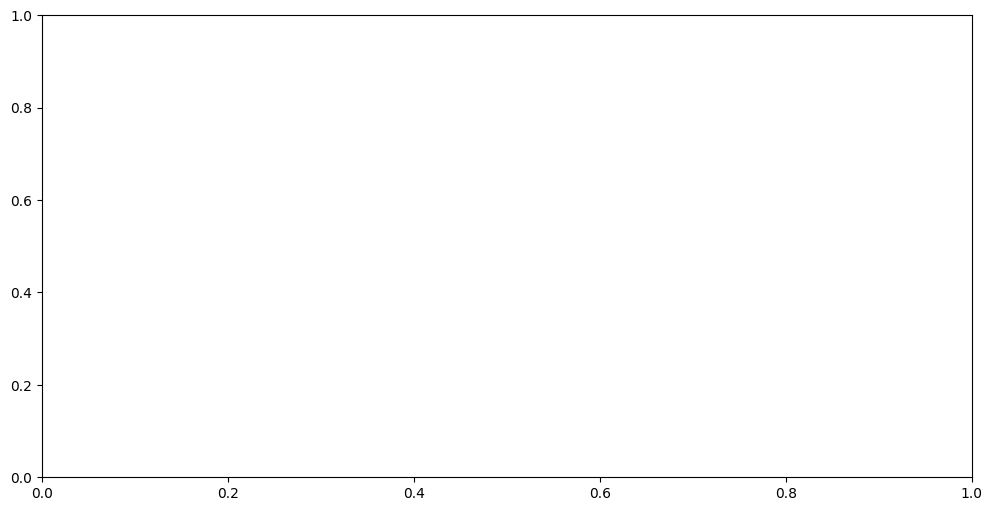

In [183]:
if __name__ == "__main__":
    # Initialize the environment and model
    eval_env = Gym2OpEnvRS(training=False)

    model = DQN(policy=BoltzmannPolicy,
            env=eval_env,
            learning_rate=1e-4,
            buffer_size=100000,
            learning_starts=1000,
            batch_size=32,
            tau=1.0,
            gamma=0.99,
            train_freq=4,
            gradient_steps=1,
            verbose=1,
            target_update_interval=1000,
            policy_kwargs={'temperature': 1.0},
        )
    
    # Load the trained model
    model = DQN.load("dqn_boltzmann_agent", env=eval_env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 20
    rewards = evaluate_agent(model, eval_env, num_episodes=num_evaluation_episodes)
    # plot_rewards(rewards)